In [ ]:
from training_phase.models import DatasetType, OriginalDataset, PreprocessingTrainingDataset, ArrayFieldTrainingDataset, PreSentenceScoring
import pandas as pd
import numpy as np
from math import sqrt, log
import os
from time import time
from collections import Counter
from sklearn import preprocessing
from sklearn.utils import resample
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import datetime
import json
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
dataset_type = DatasetType.objects.get(pk=7)
original_datasets = dataset_type.originaldataset_set.all()
sentences, f1, f2, f3, f4, f5, f6, f7, f8, f9, labels = [], [], [], [], [], [], [], [], [], [], []
for original_dataset in original_datasets:
    related_original_dataset = OriginalDataset.objects.get(pk=original_dataset.id)
    sentence_scorings = related_original_dataset.presentencescoring_set.all()
    for sentence_scoring in sentence_scorings[::-1]:
        sentences.append(sentence_scoring.sentence)
        f1.append(sentence_scoring.f1_word_frequency)
        f2.append(sentence_scoring.f2_title_similarity)
        f3.append(sentence_scoring.f3_sentence_position)
        f4.append(sentence_scoring.f4_sentence_length)
        f5.append(sentence_scoring.f5_numerical_token)
        f6.append(sentence_scoring.f6_tf_isf)
        f7.append(sentence_scoring.f7_cosim)
        f8.append(sentence_scoring.f8_bigram)
        f9.append(sentence_scoring.f9_trigram)
        labels.append(sentence_scoring.label)

In [3]:
feature = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'labels']
data = list(zip(f1, f2, f3, f4, f5, f6, f7, f8, f9, labels))
df = pd.DataFrame(data, columns=feature)
df_train = df

In [4]:
df['f1'][0]

61.0

### Comprehend Dataset

In [4]:
class ComprehendDataset:
    
    
    def __init__(self, dataset, targetclass="end"):
        self._dataset = dataset
        self._df_beforescaled = self._dataset
        self._attributes = list(self._dataset)
        if targetclass == "end":
            self._features = self._attributes
            self._feature_target = self._features[len(self._attributes)-1]
            del self._features[len(self._attributes)-1]
        elif targetclass == "begin":
            self._features = self._attributes
            self._feature_target = self._features[0]
            del self._features[0]
        self._check_missing_values = False
        self.handling_missing_values()
        self.handling_outliers()
        self.central_tendency()
        self.feature_scaling(targetclass)
        self.handling_missing_values()
        self.generate_five_number_summary()
        self.generate_target_class()
    
    
    def central_tendency(self):
        self._medians = pd.Series([self._dataset[feature].median() for feature in self._features])
        self._means = pd.Series([self._dataset[feature].mean() for feature in self._features])
        self._modes = pd.Series([self._dataset[feature].mode() for feature in self._features])
        self._list_of_Q1 = pd.Series([self._dataset[feature].quantile(0.25) for feature in self._features])
        self._list_of_Q3 = pd.Series([self._dataset[feature].quantile(0.75) for feature in self._features])
        self._list_of_IQR = pd.Series(self._list_of_Q3) - pd.Series(self._list_of_Q1)
        self._list_of_std = pd.Series([self._dataset[feature].std() for feature in self._features])
        self._list_of_std2 = self._list_of_std * 2
        self._list_of_std2_min = self._means - self._list_of_std2
        self._list_of_std2_max = self._means + self._list_of_std2
        self._upper_outliers = self._list_of_Q3 + (1.5 * self._list_of_IQR)
        self._lower_outliers = self._list_of_Q1 - (1.5 * self._list_of_IQR)
        self._list_of_min_val = pd.Series([self._dataset[feature].min() for feature in self._features])
        self._list_of_max_val = pd.Series([self._dataset[feature].max() for feature in self._features])
    
    
    def handling_outliers(self, distribution_type="nonstandard_distribution"):
        """
        option :
                1. if distribution_type = "nonstandard_distribution"
                    then
                        the value > outliers = Q1 + 1.5 * IQR
                        the value < outliers = Q1 - 1.5 * IQR
                2. if distribution_type = "standard_distribution"
                    then
                        the value > outliers = mean + std*2
                        the value < outliers = mean - std*2
        """
        self.central_tendency()
        if not self._check_missing_values:
            self.handling_missing_values()
        changes = []
        index = 0
        limit = len(self._features)-1
        self._outliers = []
        if distribution_type == "standard_distribution":
            collection_of_outlier_threshold = list(zip(self._list_of_std2_min, self._list_of_std2_max))
        elif distribution_type == "nonstandard_distribution":
            collection_of_outlier_threshold = list(zip(self._lower_outliers, self._upper_outliers))
        else:
            return "set distribution_type parameter properly"
        while index <= limit:
            indexrow = 0
            for data in self._dataset[self._features[index]]:
                if data < collection_of_outlier_threshold[index][0]:
                    changes.append("On "+self._features[index]+" Min Before : "+str(data))
                    data = collection_of_outlier_threshold[index][0]
                    changes.append("After : "+str(data))
                    self._dataset[self._features[index]].iloc[indexrow] = collection_of_outlier_threshold[index][0]
                    self._outliers.append(self._dataset[self._features[index]].iloc[indexrow])
                elif data > collection_of_outlier_threshold[index][1]:
                    changes.append("On "+self._features[index]+" Max Before : "+str(data))
                    data = collection_of_outlier_threshold[index][1]
                    changes.append("After : "+str(data))
                    self._dataset[self._features[index]].iloc[indexrow] = collection_of_outlier_threshold[index][1]
                    self._outliers.append(self._dataset[self._features[index]].iloc[indexrow])
                indexrow += 1
            index += 1
        percentage = (len(self._outliers) / (len(self._dataset) * len(self._features))) * 100
        self._outliers_percentage = str(percentage)+"%"
        self.central_tendency()
        return changes
    
    
    def handling_missing_values(self, strategy="mean"):
        self._check_missing_values = True
        self.central_tendency()
        changes = []
        indexcolumn = 0
        for feature in self._features:
            indexrow = 0
            for data in self._dataset[feature]:
                if data == 0 or data == np.nan:
                    changes.append("On feature "+feature+" row "+str(indexrow)+" Before : "+str(data))
                    if strategy == "mean":
                        self._dataset[feature].iloc[indexrow] = self._means[indexcolumn]
                        changes.append("After filled by mean = "+str(self._dataset[feature].iloc[indexrow]))
                    elif strategy == "median":
                        self._dataset[feature].iloc[indexrow] = self._medians[indexcolumn]
                        changes.append("After filled by median = "+str( self._dataset[feature].iloc[indexrow]))
                    elif strategy == "mode":
                        self._dataset[feature].iloc[indexrow] = self._modes[indexcolumn]
                        changes.append("After filled by mode = "+str( self._dataset[feature].iloc[indexrow]))
                    else:
                        return "set strategy parameter properly"
                indexrow += 1
        self.central_tendency()
        if changes:
            return changes
        return "Missing values are none"
    
    
    def generate_five_number_summary(self):
        limit = len(self._features) - 1
        index = 0
        frame = pd.DataFrame(index="min q1 med q3 max".split())
        self.central_tendency()
        while index <= limit:
            frame[self._features[index]] = [self._list_of_min_val[index], self._list_of_Q1[index], self._medians[index], self._list_of_Q3[index], self._list_of_max_val[index]]
            index += 1
        self._five_number_summary = frame
        return frame

    
    def generate_target_class(self):
        self._classes = dict(Counter(self._dataset[self._feature_target]))
        return self._classes
    
    
    def feature_scaling(self, targetclass):
        scaler = preprocessing.MinMaxScaler()
        scaled_df = scaler.fit_transform(self._dataset)
        features = self._features
        features.append(self._feature_target)
        scaled_df = pd.DataFrame(scaled_df, columns=features)
        self._dataset = scaled_df
        self._attributes = list(self._dataset)
        if targetclass == "end":
            self._features = self._attributes
            self._feature_target = self._features[len(self._attributes)-1]
            del self._features[len(self._attributes)-1]
        self.central_tendency()
    
    
    @property
    def dataset(self):
        return self._dataset
    
    @property
    def df_beforescaled(self):
        return self._df_beforescaled

    @property
    def features(self):
        return self._features
    
    @property
    def feature_target(self):
        return self._feature_target
    
    @property
    def deleted_feature(self):
        return self._deleted_features

    @property
    def medians(self):
        return self._medians
    
    @property
    def means(self):
        return self._means
    
    @property
    def modes(self):
        return self._modes

    @property
    def list_of_Q1(self):
        return self._list_of_Q1
    
    @property
    def list_of_Q3(self):
        return self._list_of_Q3
    
    @property
    def list_of_IQR(self):
        return self._list_of_std
    
    @property
    def list_of_std(self):
        return self._list_of_std
    
    @property
    def list_of_std2(self):
        return self._list_of_std2
    
    @property
    def list_of_std2_max(self):
        return self._list_of_std2_max
    
    @property
    def list_of_std2_min(self):
        return self._list_of_std2_min
    
    @property
    def list_of_min_val(self):
        return self._list_of_min_val
    
    @property
    def list_of_max_val(self):
        return self._list_of_max_val
    
    @property
    def outliers(self):
        return self._outliers

    @property
    def outliers_percentage(self):
        return self._outliers_percentage

    @property
    def five_number_summary(self):
        return self._five_number_summary

    @property
    def classes(self):
        return self._classes

In [5]:
start = time()
comprehend_dataset = ComprehendDataset(df)
end = time()
print(f"Runtime = {end-start}")

/home/wolio/.local/share/virtualenvs/auto-summarizer-Nu1b5w2g/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Runtime = 1.8869497776031494


In [45]:
comprehend_dataset.dataset['f1'][4]

0.014705882352941176

# Bootstrap Aggregating

In [6]:
class Bagging:
    
    
    def __init__(self, dataset, number_of_bootstrap=50):
        self._dataset = dataset
        self._attributes = list(self._dataset)
        self._features = self._attributes
        self._number_of_bootstrap = number_of_bootstrap
        self._feature_target = self._features[len(self._attributes)-1]
        del self._features[len(self._attributes)-1]
        self.sample_size()
        self.sample_attributes()
        self.bootstrap_aggregating()
    
    
    def sample_size(self):
        len_dataset = len(self._dataset.index)
        self._bootstrap_size = round((2/3*len_dataset))
        
    
    def sample_attributes(self):
        self._listof_bagging_features = []
        bagging_feature = round(sqrt(len(self._features)))
        for i in range(self._number_of_bootstrap):
            self._listof_bagging_features.append(list(resample(self._features, replace=False, n_samples=bagging_feature)))
    
    
    def bootstrap_aggregating(self):
        self._listof_bagging = []
        self._listof_oob = []
        temp_bagging = []
        for i in range(self._number_of_bootstrap):
            features = self._listof_bagging_features[i]
            temp_features = features
            get_index = False
            bag_lists = []
            oob_lists = []
            for feature in features:
                if not get_index:
                    current_boot = resample(self._dataset[feature], replace=True, n_samples=self._bootstrap_size)
                    current_boot_index = list(current_boot.index)
                    real_data_index = [k for k in range(len(self._dataset.index))]
                    oob_index = [x for x in real_data_index if x not in current_boot_index]
                    bag_lists.append(list(current_boot))
                    get_index = True
                    oob_feature_target = []
                    current_boot_feature_target = []
                    for j in current_boot_index:
                        current_boot_feature_target.append(self._dataset[self._feature_target][j])
                    oob_list = []
                    for l in oob_index:
                        oob_list.append(self._dataset[feature][l])
                        oob_feature_target.append(self._dataset[self._feature_target][l])
                    oob_lists.append(oob_list)
                else:
                    bag_list = []
                    for j in current_boot_index:
                        bag_list.append(self._dataset[feature][j])
                    bag_lists.append(bag_list)
                    oob_list = []
                    for l in oob_index:
                        oob_list.append(self._dataset[feature][l])
                    oob_lists.append(oob_list)
            bag_lists.append(current_boot_feature_target)
            oob_lists.append(oob_feature_target)
            temp_features.append('labels')
            datum = {}
            for i in range(len(temp_features)):
                datum[temp_features[i]] = bag_lists[i]
            df = pd.DataFrame(data=datum)
            self._listof_bagging.append(df)
            datum = {}
            for i in range(len(temp_features)):
                datum[temp_features[i]] = oob_lists[i]
            df = pd.DataFrame(data=datum)
            self._listof_oob.append(df)


    @property
    def dataset(self):
        return self._dataset
    @property
    def bootstrap_size(self):
        return self._bootstrap_size
    @property
    def listof_bagging_features(self):
        return self._listof_bagging_features
    @property
    def listof_bagging(self):
        return self._listof_bagging
    @property
    def listof_oob(self):
        return self._listof_oob

In [7]:
bagging = Bagging(comprehend_dataset.dataset)

In [17]:
bagging.listof_bagging[1]

f4        f2        f7  labels
0     0.671815  0.012104  1.000000     0.0
1     0.610039  1.000000  0.122538     0.0
2     0.563707  0.010270  0.148796     0.0
3     0.362934  0.005502  0.017505     1.0
4     0.108108  1.000000  1.000000     0.0
...        ...       ...       ...     ...
1460  0.231660  1.000000  0.052516     0.0
1461  0.108108  0.000367  1.000000     0.0
1462  0.478764  0.006969  0.065646     1.0
1463  0.131274  1.000000  1.000000     0.0
1464  0.416988  1.000000  0.083151     0.0

[1465 rows x 4 columns]

# Random Forest :: C4.5 Classifier

- [x] Information Gain
- [x] Split Information
- [x] Gain Ratio
- [x] Output : rules
- [x] For the next dataset, still ambiguous, digest more on interval
- [x] Save rules into static file

In [85]:
class RandomForest:
    
    
    def __init__(self, list_of_bags):
        self._rules = []
        self._tree = {}
        self._list_of_bags = list_of_bags
        self._iter_left = True
        self._iter_right = False
        self.random_forest_exec(self._list_of_bags)
    
    
    @property
    def rules(self):
        return self._rules
    
    
    def random_forest_exec(self, list_of_bags):
        for bag in list_of_bags:
            self._dataset = bag
            self._attributes = list(self._dataset)
            self._features = self._attributes
            self._feature_target = self._features[len(self._attributes)-1]
            self._dataset
            del self._features[len(self._attributes)-1]
            gain_ratio_stats, index_main_interval = self.gain_ratio(self._dataset, self._features)
            dataset_partials, next_feature, next_iter = self.get_max_gain(gain_ratio_stats, index_main_interval)
            for dataset in dataset_partials:
                compact_gain_ratio, compact_counter_index_interval = self.gain_ratio(dataset, next_feature)
                self.get_max_gain(compact_gain_ratio, compact_counter_index_interval, next_feature)
            self._rules.append(self._tree)
            self._tree = {}
    
    
    def get_max_gain(self, gain_ratio_stats, index_main_interval, temp_feature="none"):
        list_compact_stat = []
        for gain_ratio_stat in gain_ratio_stats:
            compact_stat = {}
            list_gain_ratio = list(gain_ratio_stat['gain_ratio'])
            max_val = gain_ratio_stat['gain_ratio'].max()
            max_index = list_gain_ratio.index(max(list_gain_ratio))
            compact_stat[max_index] = max_val
            list_compact_stat.append(compact_stat)
        max_value = 0
        key_maximum = 0
        for stat in list_compact_stat:
            for key, value in stat.items():
                if max_value < value:
                    max_value = value
                    key_maximum = key
        i = 0
        next_feature = []
        if temp_feature == "none":
            for stat in list_compact_stat:
                for key, value in stat.items():
                    if max_value == value:
                        index_max_feature = i
                        i += 1
                    else:
                        next_feature.append(self._features[i])
                        i += 1
        else:
            for stat in list_compact_stat:
                for key, value in stat.items():
                    if max_value == value:
                        index_max_feature = i
                        i += 1
                    else:
                        next_feature.append(temp_feature[i])
                        i += 1
        if 'root' not in self._tree:
            parent_max_feature = self._features[index_max_feature]
            self._tree['root'] = {}
            self._tree['root']['feature'] = parent_max_feature
            self._tree['root']['interval'] = max_value
            self._tree['root']['left_node'] = {}
            self._tree['root']['right_node'] = {}
        else:
            max_feature = temp_feature[index_max_feature]
            output_labels = index_main_interval[index_max_feature]['interval_partials'][key_maximum]
            # print(output_labels)
            final_decision = []
            list_key = []
            check_null_samples = False
            for output_label in output_labels:
                max_output = 0
                max_key = 0
                for key, values in output_label.items():
                    if max_output < values:
                        max_output = values
                        max_key = key
                    if values == 0:
                        check_null_samples = True
                    list_key.append(key)
                final_decision.append(max_key)
            list_key = set(list_key)
            list_key = list(list_key)
            check_decision = set(final_decision)
            if not check_null_samples:
                if len(output_labels[0]) == 2:
                    if len(check_decision) == 1:
                        final_decision = []
                        max_list_opt = []
                        for output_label in output_labels:
                            max_output = 0
                            max_key = 0
                            pact_opt = {}
                            for key, values in output_label.items():
                                if max_output < values:
                                    max_output = values
                                    max_key = key
                            pact_opt[max_key] = max_output
                            max_list_opt.append(pact_opt)
                        temp_opt = 0
                        temp_key = 0
                        loc_post = 0
                        for i, pact in enumerate(max_list_opt):
                            for key, values in pact.items():
                                if temp_opt < values:
                                    temp_opt = values
                                    temp_key = key
                                    loc_post = i
                        for i, output_label in enumerate(output_labels):
                            max_output = 0
                            max_key = 0
                            for key, values in output_label.items():
                                if max_output < values:
                                    max_output = values
                                    max_key = key
                            if i != loc_post:
                                if temp_key == max_key:
                                    if temp_key == list_key[0]:
                                        max_key = list_key[1]
                                    else:
                                        max_key = list_key[0]
                            final_decision.append(max_key)
            # print(final_decision)
            self.initiate_next_node(self._tree['root'], max_feature, max_value, final_decision)
        next_datasets = index_main_interval[index_max_feature]['index_dataset'][key_maximum]
        dataset_partials = self.update_next_dataset(next_feature, next_datasets)
        self._dataset_part = dataset_partials
        next_iter = len(dataset_partials)
        del next_feature[len(next_feature)-1]
        return dataset_partials, next_feature, next_iter
    
    
    def initiate_next_node(self, rules_tree, max_feature, max_value, final_decision):
        for key, value in rules_tree.items():
            if key == 'left_node':
                if self._iter_left:
                    if 'interval' not in value:
                        value['feature'] = max_feature
                        value['interval'] = max_value
                        value['output'] = {}
                        value['output']['left'] = final_decision[0]
                        value['output']['right'] = final_decision[1]
                        self._iter_left = False
                        self._iter_right = True
                        return
            if key == 'right_node':
                if self._iter_right:
                    if 'interval' not in value:
                        value['feature'] = max_feature
                        value['interval'] = max_value
                        value['output'] = {}
                        value['output']['left'] = final_decision[0]
                        value['output']['right'] = final_decision[1]
                self._iter_left = True
                self._iter_right = False
    
    
    def generate_entropy(self, dataset, counters="none", general_entropy="none"):
        if counters == "none":
            class_counter = self.target_class_counter(dataset)
            total_sample = len(dataset.index)
            results = []
            for key, value in class_counter.items():
                calc = -(value/total_sample)*log((value/total_sample),2)
                results.append(calc)
            entropy = 0
            for result in results:
                entropy += result
            return entropy, class_counter
        else:
            total_value = 0
            total_samples = []
            for counter in counters:
                total_sample = 0
                for key, value in counter.items():
                    total_value += value
                    total_sample += value
                total_samples.append(total_sample)
            compact_entropy = []
            information_gain = general_entropy
            split_information = 0
            result = 0
            for i, counter in enumerate(counters):
                entropy = 0
                for key, value in counter.items():
                    try:
                        entropy += -(value/total_samples[i])*log((value/total_samples[i]),2)
                    except (ZeroDivisionError, ValueError):
                        entropy += 0
                try:
                    split_information += -(total_samples[i]/total_value)*log((total_samples[i]/total_value),2)
                except (ZeroDivisionError, ValueError):
                    split_information += 0
                result += (total_samples[i]/total_value)*entropy
            information_gain -= result
            try:
                gain_ratio = information_gain/split_information
            except (ZeroDivisionError, ValueError):
                gain_ratio = 0
            return information_gain, split_information, gain_ratio
    
    
    def target_class_counter(self, dataset):
        return dict(Counter(dataset[self._feature_target]))
    
    
    def gain_ratio(self, dataset, features):
        compact_gain_ratio = []
        compact_counter_index_interval = []
        general_entropy, class_counter = self.generate_entropy(dataset)
        for feature in features:
            intervals = list(set(list(dataset[feature])))
            intervals.sort()
            interval_partials = []
            dataset_index_partials = []
            ig_list = []
            split_information_list = []
            gain_ratio_list = []
            for interval in intervals:
                interval_partial = []
                dataset_index_partial = []
                counter_interval_lower = {}
                counter_interval_upper = {}
                dataset_index_lower = {}
                dataset_index_upper = {}
                for i, value in enumerate(list(dataset[feature])):
                    if value <= interval:
                        if dataset[self._feature_target][i] in counter_interval_lower:
                            counter_interval_lower[dataset[self._feature_target][i]] += 1
                            dataset_index_lower[dataset[self._feature_target][i]].append(i)
                        else:
                            counter_interval_lower[dataset[self._feature_target][i]] = 1
                            dataset_index_lower[dataset[self._feature_target][i]] = []
                            dataset_index_lower[dataset[self._feature_target][i]].append(i)
                    else:
                        if dataset[self._feature_target][i] in counter_interval_upper:
                            counter_interval_upper[dataset[self._feature_target][i]] += 1
                            dataset_index_upper[dataset[self._feature_target][i]].append(i)
                        else:
                            counter_interval_upper[dataset[self._feature_target][i]] = 1
                            dataset_index_upper[dataset[self._feature_target][i]] = []
                            dataset_index_upper[dataset[self._feature_target][i]].append(i)
                if not counter_interval_lower:
                    for key, value in class_counter.items():
                        counter_interval_lower[key] = 0
                if not counter_interval_upper:
                    for key, value in class_counter.items():
                        counter_interval_upper[key] = 0
                if len(counter_interval_lower) != len(class_counter):
                    for key, value in class_counter.items():
                        if key not in counter_interval_lower:
                            counter_interval_lower[key] = 0
                if len(counter_interval_upper) != len(class_counter):
                    for key, value in class_counter.items():
                        if key not in counter_interval_upper:
                            counter_interval_upper[key] = 0
                if not dataset_index_lower:
                    for key, value in class_counter.items():
                        dataset_index_lower[key] = []
                if not dataset_index_upper:
                    for key, value in class_counter.items():
                        dataset_index_upper[key] = []
                if len(dataset_index_lower) != len(class_counter):
                    for key, value in class_counter.items():
                        if key not in dataset_index_lower:
                            dataset_index_lower[key] = []
                if len(dataset_index_upper) != len(class_counter):
                    for key, value in class_counter.items():
                        if key not in dataset_index_upper:
                            dataset_index_upper[key] = []
                compact = []
                interval_partial.append(counter_interval_lower)
                interval_partial.append(counter_interval_upper)
                dataset_index_partial.append(dataset_index_lower)
                dataset_index_partial.append(dataset_index_upper)
                dataset_index_partials.append(dataset_index_partial)
                ig, split_information, gain_ratio = self.generate_entropy(dataset, interval_partial, general_entropy)
                interval_partials.append(interval_partial)
                ig_list.append(ig)
                split_information_list.append(split_information)
                gain_ratio_list.append(gain_ratio)
            datum = {'interval': intervals, 'ig': ig_list, 'split_information': split_information_list, 'gain_ratio': gain_ratio_list}
            df = pd.DataFrame(data=datum)
            compact_gain_ratio.append(df)
            datum = {'interval': intervals, 'interval_partials': interval_partials, 'index_dataset': dataset_index_partials}
            df = pd.DataFrame(data=datum)
            compact_counter_index_interval.append(df)
        return compact_gain_ratio, compact_counter_index_interval
    
    
    def update_next_dataset(self, next_feature, next_datasets):
        bound = len(next_datasets)
        list_of_dataset = []
        next_feature.append(self._feature_target)
        for i in range(bound):
            datum = {}
            for feature in next_feature:
                for key, indexes in next_datasets[i].items():
                    for index in indexes:
                        if feature in datum:
                            datum[feature].append(self._dataset[feature][index])
                        else:
                            datum[feature] = []
                            datum[feature].append(self._dataset[feature][index])
            df = pd.DataFrame(data=datum)
            list_of_dataset.append(df)
        return list_of_dataset

In [86]:
start = time()
dec_tree = RandomForest(bagging.listof_bagging)
end = time()
result = end-start
print(str(datetime.timedelta(seconds=result)))

0:12:18.938572


In [122]:
t_struct = dec_tree._rules[35]
print(json.dumps(t_struct, sort_keys=True, indent=4))

{
    "root": {
        "feature": "f4",
        "interval": 0.07127972568414946,
        "left_node": {
            "feature": "f9",
            "interval": 0.03336583375398521,
            "output": {
                "left": 0.0,
                "right": 1.0
            }
        },
        "right_node": {
            "feature": "f9",
            "interval": 0.12208787979097273,
            "output": {
                "left": 1.0,
                "right": 0.0
            }
        }
    }
}


### Save rules into static file

In [123]:
import os
BASE_DIR = os.path.abspath('')

In [124]:
file_path_loc = os.path.join(BASE_DIR, 'training_phase/rules/decision_rules.txt')

In [127]:
for rule in dec_tree.rules:
    with open(file_path_loc, 'a') as file:
        file.writelines(json.dumps(rule, sort_keys=True, indent=4))
        file.writelines("\n")

In [134]:
file_path_loc = os.path.join(BASE_DIR, 'training_phase/rules/decisions.txt')

In [135]:
for rule in dec_tree.rules:
    with open(file_path_loc, 'a') as file:
        file.writelines(json.dumps(rule))
        file.writelines("\n")

### Individual Bag

In [82]:
list_bag = []
list_bag.append(bagging.listof_bagging[1])
start = time()
dec_tree = RandomForest(list_bag)
end = time()
result = end-start

print(str(datetime.timedelta(seconds=result)))

[{0.0: 31, 1.0: 22}, {0.0: 1030, 1.0: 284}]
[1.0, 0.0]
[{1.0: 2, 0.0: 7}, {1.0: 4, 0.0: 85}]
[1.0, 0.0]
0:00:09.848602


In [83]:
t_struct = dec_tree._rules[0]
print(json.dumps(t_struct, sort_keys=True, indent=4))

{
    "root": {
        "feature": "f9",
        "interval": 0.02562565132971172,
        "left_node": {
            "feature": "f5",
            "interval": 0.022491599103437815,
            "output": {
                "left": 1.0,
                "right": 0.0
            }
        },
        "right_node": {
            "feature": "f5",
            "interval": 0.04943754452346706,
            "output": {
                "left": 1.0,
                "right": 0.0
            }
        }
    }
}


#### Get index max in dict

In [24]:
key_maximum = max(dec_tree._compact_parent_stat, key = dec_tree._compact_parent_stat.get)
print(key_maximum, dec_tree._compact_parent_stat[key_maximum])

71 0.08231730114200347


#### Index == Order of feature
```python
index_interval[0]
```

#### Get index max
```python
at = list(ig[0]['ig'])
print(at.index(max(at)))
>> 64
```

## Scaling Visualization

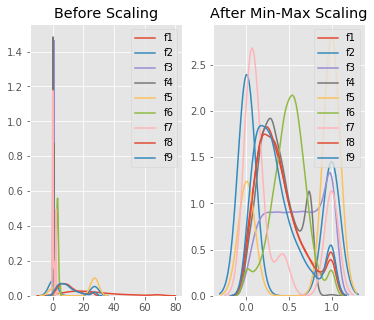

In [69]:
scaler = preprocessing.MinMaxScaler()
scaled_df = scaler.fit_transform(df_train)
scaled_df = pd.DataFrame(scaled_df, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'labels'])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df_train['f1'], ax=ax1)
sns.kdeplot(df_train['f2'], ax=ax1)
sns.kdeplot(df_train['f3'], ax=ax1)
sns.kdeplot(df_train['f4'], ax=ax1)
sns.kdeplot(df_train['f5'], ax=ax1)
sns.kdeplot(df_train['f6'], ax=ax1)
sns.kdeplot(df_train['f7'], ax=ax1)
sns.kdeplot(df_train['f8'], ax=ax1)
sns.kdeplot(df_train['f9'], ax=ax1)
ax2.set_title('After Min-Max Scaling')
sns.kdeplot(scaled_df['f1'], ax=ax2)
sns.kdeplot(scaled_df['f2'], ax=ax2)
sns.kdeplot(scaled_df['f3'], ax=ax2)
sns.kdeplot(scaled_df['f4'], ax=ax2)
sns.kdeplot(scaled_df['f5'], ax=ax2)
sns.kdeplot(scaled_df['f6'], ax=ax2)
sns.kdeplot(scaled_df['f7'], ax=ax2)
sns.kdeplot(scaled_df['f8'], ax=ax2)
sns.kdeplot(scaled_df['f9'], ax=ax2)
plt.show()